In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2 as cv

# defined
from utility_function import img_resize, model_namer, model_namer_description, save_ml_model, load_ml_model, load_training_data

In [3]:
# model testing

# filename = '3d_cnn2.h5'
# filename = '3d_cnn3.h5'
# img_resize_factor = 100

# filename = 'cnn3d_100_5_1.75e-14_100_1_relu_50.h5'
# filename = 'cnn3d_100_5_1.75e-14_50_1_relu_50.h5'
# filename = 'cnn3d_1000_5_1.75e-14_40_1_tanh_1.h5'
# filename = 'cnn2d_1000_5_1.75e-14_50_1_relu_100.h5'
# filename = 'cnn2d_1000_5_1.75e-14_100_1_tanhmax_100.h5'
# filename = 'cnn3d_2000_5_1.75e-14_50_1_relu-dense_1.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
# filename = 'cnn2d_v1_1000_5_1.75e-14_50_max-based_100.pkl'
# filename = 'cnn2d_v2_1000_5_1.75e-14_50_shrinkX_100.pkl'
# filename = 'cnn3d_v1_1000_5_1.75e-14_50_shrinkX-tanh_10.pkl' # do not predict anything
# filename = 'cnn2d_v3_1000_5_1.75e-14_50_stack-2d_10.pkl' # do not predict anything
# filename = 'cnn2d_v3_1000_5_1.75e-14_50_no-pooling_100.pkl' # do not predict anything
# filename = 'cnn2d_v4_1000_5_1.75e-14_50_pooling_100.pkl'
filename = 'cnn3d_v2_1000_5_1.75e-14_50_pooling_100.pkl'
# filename = 'cnn3d_v3_1000_5_1.75e-14_50_2-3dconv_100.pkl' # do not predict anything
# filename = 'cnn3d_v3_1000_5_1.75e-14_50_pooling-lr_100.pkl'

info = model_namer_description(filename)
model = load_ml_model(filename)
model.summary()

Model description:
 
                - Dimension: 3
 
                - Version: v2

                - Number of samples: 1000

                - FMC subsampling frequency: 5

                - FMC scaler: 1.75e-14

                - Img resize factor: 50

                - Remark: pooling

                - Epochs: 100

    
Metal device set to: Apple M1 Pro


2023-02-23 10:37:40.439301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 10:37:40.439449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 861, 14, 14, 2)    92        
                                                                 
 dropout (Dropout)           (None, 861, 14, 14, 2)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 430, 7, 7, 2)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 42140)             0         
                                                                 
 dense (Dense)               (None, 1000)              42141000  
                                                                 
 dense_1 (Dense)             (None, 7200)              7207200   
                                                        

In [4]:
x_dimension = int(info['Dimension'])
img_resize_factor = int(info['img_resize'])
epochs = int(info['epochs'])
shrinkx = True

X, y = load_training_data(num_sample=3500, 
                          x_dimension=x_dimension, 
                          img_resize_factor=img_resize_factor,
                          shrinkx = shrinkx)

The original shape of X is (3500, 895, 16, 16, 1)
The shape of X after shrinking is (3500, 865, 16, 16, 1)
The shape of y is (3500, 7200)


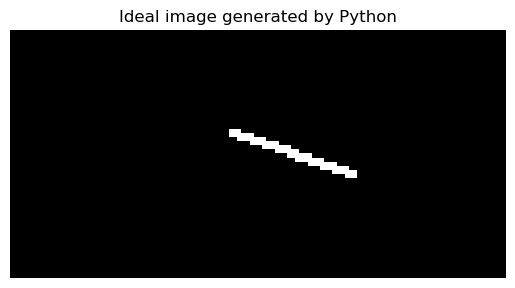

1/1 [==============================] - 0s 40ms/step


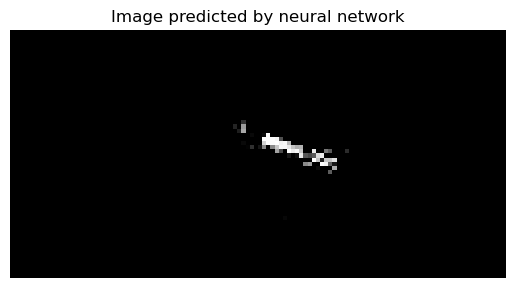

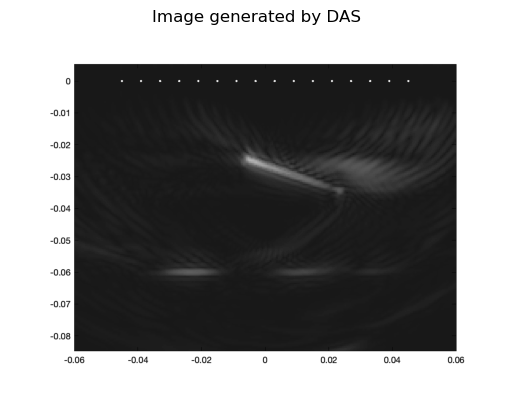

In [8]:
# 1078 # 1073 # 1070
num_test = 3400
threshold = -0.1 
stack = False

true_img = y[num_test].reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
fig, ax = plt.subplots()
ax.imshow(true_img, cmap ='gray')
plt.title('Ideal image generated by Python')
plt.axis('off')
plt.show()

if shrinkx == True:
    xshape = 865
else:
    xshape = 895

if x_dimension == 3:
    ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16, 1))
elif x_dimension == 2:
    if stack == True:
        ypred = model.predict(X[num_test].reshape(-1, xshape, 16, 16))
    else:
        ypred = model.predict(X[num_test].reshape(-1, xshape, 16*16, 1))
    
ypred[ypred <= threshold] = 0
ypred[ypred > threshold] = np.abs(ypred[ypred > threshold])*255
img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
fig, ax = plt.subplots()
ax.imshow(img, cmap ='gray')
plt.title('Image predicted by neural network')
plt.axis('off')
plt.show()

dirName_das_fmc = "/Users/chenkangan/Desktop/ME4_FYP/imageGenerate_2022/DAS_Figure_FMC"
# Read image in greyscale 
image_das_fmc = cv.imread(f'{dirName_das_fmc}/Figure_{num_test+1}_fmc.png',cv.IMREAD_GRAYSCALE)  # convert to array

plt.imshow(image_das_fmc, cmap='gray')
plt.title('Image generated by DAS')
plt.axis('off')
plt.show()

In [62]:
np.sum(ypred)

0.0